# Installations and setup

In [ ]:
! pip install chess -q
! pip install kaggle -q
! pip install torch
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
import chess
import pandas as pd
import numpy as np
import re

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gc

In [ ]:
letter_2_num = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'h':7}

num_2_letter = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g', 7:'h'}

In [ ]:
# takes board from python's chess package and converts it to a matrix representation
def board_2_rep(board):
  pieces = ['p', 'r', 'n', 'b', 'q', 'k']
  layers = []
  for piece in pieces:
    layers.append(create_rep_layer(board, piece))
  board_rep = np.stack(layers)
  return board_rep.astype(float)  # matrix represenation of the board

In [ ]:
def create_rep_layer(board, type):

  # takes board represenation from chess package and isolates the type of piece
  # we are looking at and zeroing out the rest of the matrix
  s = str(board)
  s = re.sub(f'[^{type}{type.upper()} \n]', '.', s)
  s = re.sub(f'{type}', '-1', s)
  s = re.sub(f'{type.upper()}', '1', s)
  s = re.sub(f'\\.', '0', s)

  # converting to a numpy matrix
  board_mat = []
  for row in s.split('\n'):
    row = row.split(' ')
    row = [int(x) for x in row]
    board_mat.append(row)

  return np.array(board_mat)

# Test `board_2_rep` and `create_rep_layer` ✅

In [ ]:
board = chess.Board()

In [ ]:
board

In [ ]:
matrix_board = board_2_rep(board)

In [ ]:
matrix_board

# Test `move_2_rep` and `create_move_list` ✅

In [ ]:
def move_2_rep(move, board):

  # convert algebraic notation into uci notation:
  # (four numbers: column, row, piece start, piece end)
  board.push_san(move).uci()
  move = str(board.pop())

  # We have a matrix representing where the piece was
  # and another for where the piece is going.
  #
  from_output_layer = np.zeros((8,8))
  from_row = 8 - int(move[1])
  from_column = letter_2_num[move[0]]
  from_output_layer[from_row, from_column] = 1

  to_output_layer = np.zeros((8,8))
  to_row = 8 - int(move[3])
  tow_column = letter_2_num[move[2]]
  to_output_layer[to_row, tow_column] = 1

  return np.stack([from_output_layer, to_output_layer])

In [ ]:
board = chess.Board()

x = move_2_rep("e4", board)
board.push_san("e4")

print(x)

board

In [ ]:
def create_move_list(s):
    return re.sub(r'\d*\. ', '', s).split(' ')[:-1]

In [ ]:
moves_str1 = "1. e4 e5 2. Nf3 Nc6 3. Bb5 a6"

In [ ]:
create_move_list(moves_str1)

In [ ]:
moves_str2 = "1. e4 c5 2. Nf3 d6 3. d4 cxd4"
create_move_list(moves_str2)

# Get the data and test it ✅

In [ ]:
# ! kaggle datasets download -d arevel/chess-games

In [ ]:
# ! unzip -qq chess-games.zip

In [ ]:
data = pd.read_csv('./chess_games.csv', usecols=['AN', 'WhiteElo'])

In [ ]:
data = data[data['WhiteElo'] > 2000] # we can change elo to add more data
data = data[['AN']]
data = data[~data['AN'].str.contains('{')]
data = data[data['AN'].str.len() > 20]

In [ ]:
data

In [ ]:
game1 = data.iloc[0,0]
game_moves = create_move_list(game1)
print(game_moves)
len(game_moves)

# Define the neural network ✅

In [ ]:
class ChessNet(nn.Module):
    def __init__(self, hidden_layers=4, hidden_size=200):
        super(ChessNet, self).__init__()
        self.hidden_layers = hidden_layers
        self.input_layer = nn.Conv2d(6, hidden_size, 3, stride=1, padding=1)
        self.module_list = nn.ModuleList([module(hidden_size) for i in range(hidden_layers)])
        self.output_layer = nn.Conv2d(hidden_size, 2, 3, stride=1, padding=1)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)

        for i in range(self.hidden_layers):
            x = self.module_list[i](x)

        x = self.output_layer(x)

        return x

In [ ]:
class module(nn.Module):

    def __init__(self, hidden_size):
        super(module,self).__init__()
        self.conv1 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.bn2 = nn.BatchNorm2d(hidden_size)
        self.activation1 = nn.SELU()
        self.activation2 = nn.SELU()

    def forward(self, x):
        x_input = torch.clone(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + x_input
        x = self.activation2(x)
        return x

# Helper methods for training/testing

In [ ]:
def pred_to_move(move, board):
#     move = move[0]

    legal_moves = list(board.legal_moves)

    vals = []
    froms = [str(legal_move)[:2] for legal_move in legal_moves]
    froms = list(set(froms))

    for from_ in froms:
        r = 8 - int(from_[1])
        c = letter_2_num[from_[0]]
        val = move[0, r, c].detach().cpu().numpy()
        vals.append(val)

    probs = distribution_over_moves(vals)
    choosen_from = str(np.random.choice(froms, size=1, p=probs)[0])[:2]

    vals = []
    for legal_move in legal_moves:
        from_ = str(legal_move)[:2]
        if from_ == choosen_from:
            to = str(legal_move)[2:]
            r = 8 - int(to[1])
            c = letter_2_num[to[0]]
            val = move[1, r, c].detach().cpu().numpy()
            vals.append(val)
        else:
            vals.append(0)

    choosen_move = legal_moves[np.argmax(vals)]
    return choosen_move

In [ ]:
# We might remove this later. This ensures that some randomness in moves is maintained.
def distribution_over_moves(vals):
    probs = np.array(vals)
    probs = np.exp(probs)
    probs = probs / probs.sum()
    probs = probs ** 3
    probs = probs / probs.sum()
    return probs

# Create the Data Loader

In [ ]:
class ChessDataset(Dataset):

    def __init__(self, games):
        super(ChessDataset, self).__init__()
        self.games = games

    def __len__(self):
        # return 1_500_000 # random large number
        return 40_000

    def __getitem__(self, index):
        game_i = np.random.randint(len(self.games))
        random_game = data['AN'].values[game_i]
        moves = create_move_list(random_game)
        game_state_i = np.random.randint(len(moves))
        next_move = moves[game_state_i]
        moves = moves[:game_state_i]
        board = chess.Board()
        for move in moves:
            board.push_san(move)
        x = board_2_rep(board)
        y = move_2_rep(next_move, board)
        if game_state_i % 2 == 1:
            x *= -1
        return x, y

In [ ]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

data_train = ChessDataset(train_dataset)
data_test = ChessDataset(test_dataset)

data_train_loader = DataLoader(data_train, batch_size=32, drop_last=True)
data_test_loader = DataLoader(data_test, batch_size=32, drop_last=True)

# Train the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
model = ChessNet().to(device)

In [ ]:
def train_loop(dataloader, model, metric_from, metric_to, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (board_state, correct_move) in enumerate(dataloader):

        board_state, correct_move = board_state.to(device), correct_move.to(device)

        # Compute prediction and loss
        pred = model(board_state.float())

        loss = metric_from(pred[:,0,:,:], correct_move[:,0,:,:]) + metric_to(pred[:,1,:,:], correct_move[:,1,:,:])

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * batch_size + len(board_state)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Test the model ✅

In [ ]:
def test_loop(dataloader, model):

    num_guesses = 0
    correct = 0
    batch_number = 0

    model.eval()

    with torch.no_grad():
        for batch, (board_state, correct_move) in enumerate(dataloader):

            board_state, correct_move = board_state.to(device), correct_move.to(device)

            index = 0  # index of correct_move in the batch (0-32)
            preds = model(board_state.float())

#             print("new batch of predictions, batch number: ", batch_number)
            for pred in preds:
                UCI = pred_to_move(pred)
                AN = str(UCI)[-2:]  # Get the last two characters of the string

                matrix_move = move_2_rep(AN, board)   # get one prediction
                correct_move_np = correct_move[index].cpu().numpy()    # get the corresponding correct move

                if np.array_equal(matrix_move, correct_move_np):
                    correct += 1

                num_guesses += 1
                index += 1

            batch_number += 1
#             print("num correct", correct)
#             print(" ")

    print("number of total guesses: ", num_guesses)
    print("number of correct guesses: ", correct)
    print("accuracy: ", (correct/num_guesses)*100)

In [ ]:
learning_rate = 1e-3
batch_size = 32

metric_from = nn.CrossEntropyLoss()
metric_to = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 2
# epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(data_train_loader, model, metric_from, metric_to, optimizer)
    test_loop(data_test_loader, model)
print("Done!")

In [ ]:
def get_ai_move(board, model):
    mat_move = board_2_rep(board)
    mat_move = np.expand_dims(mat_move, axis=0)  # Add a batch dimension
    mat_move_tensor = torch.tensor(mat_move)  # Convert to PyTorch tensor
    move = model(mat_move_tensor.float().to(device))
    uci = pred_to_move(move[0], board)
    return uci


In [ ]:
def get_player_move(board):
    while True:
        user_move = input("Enter your move (in algebraic notation, e.g., e2e4): ")
        if user_move in [move.uci() for move in board.legal_moves]:
            return user_move
        else:
            print("Invalid move. Please enter a valid move.")

In [86]:
def game_loop():
    board = chess.Board()
    display(board)
    
    while not board.is_game_over():
        ai_move = get_ai_move(board, model)  
        board.push_uci(str(ai_move))
        print("AI's move:", ai_move)
        display(board)
        
        if board.is_game_over():
            break

        # Player's move|
        player_move = get_player_move(board)
        board.push_uci(str(player_move))
        print("Player's move:", player_move)
        display(board)

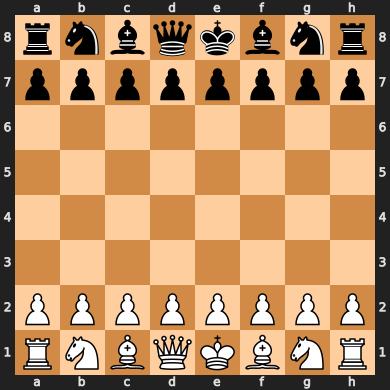

AI's move: e2e4


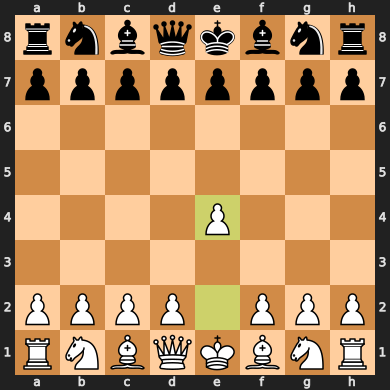

Enter your move (in algebraic notation, e.g., e2e4):  e7e5


Player's move: e7e5


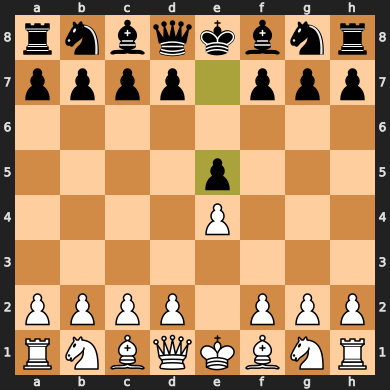

AI's move: d2d4


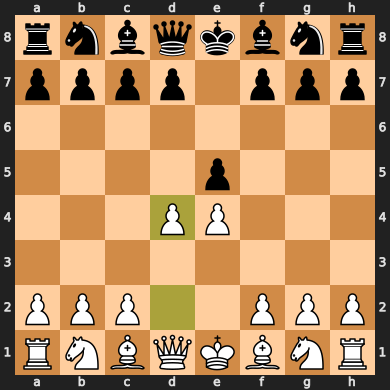

Enter your move (in algebraic notation, e.g., e2e4):  d7d6


Player's move: d7d6


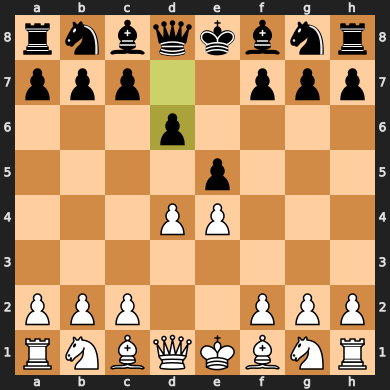

AI's move: f1e2


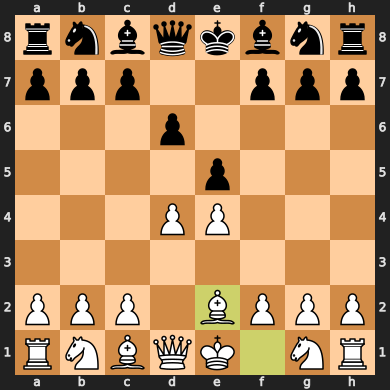

Enter your move (in algebraic notation, e.g., e2e4):  g8f6


Player's move: g8f6


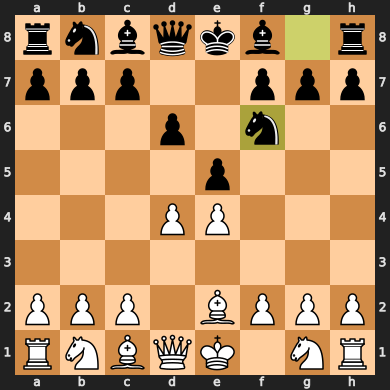

AI's move: f2f3


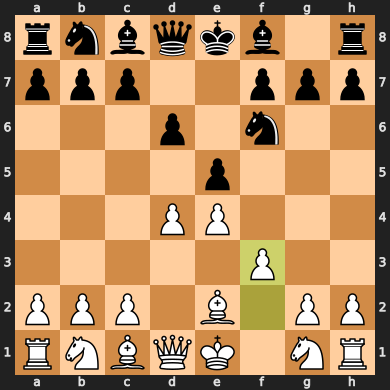

Enter your move (in algebraic notation, e.g., e2e4):  b8c6


Player's move: b8c6


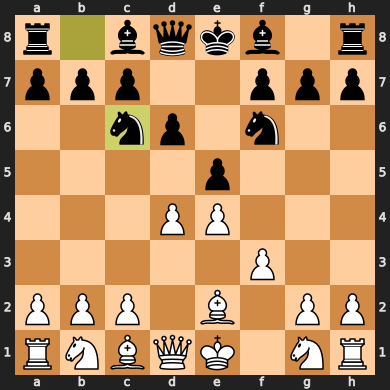

AI's move: d4e5


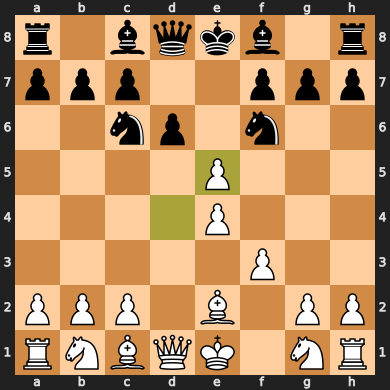

Enter your move (in algebraic notation, e.g., e2e4):  d6e5


Player's move: d6e5


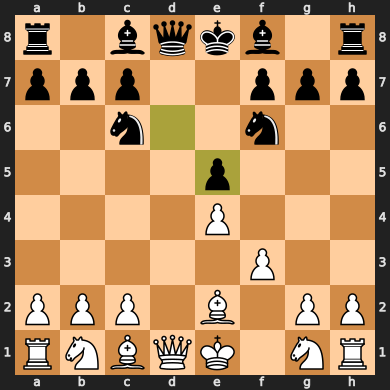

AI's move: g1h3


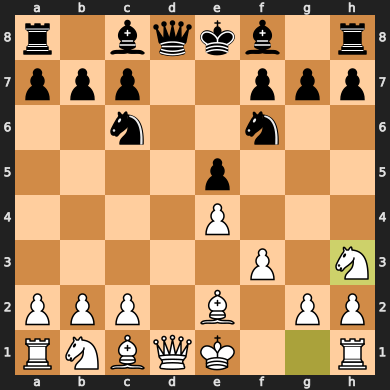

Enter your move (in algebraic notation, e.g., e2e4):  d8d1


Player's move: d8d1


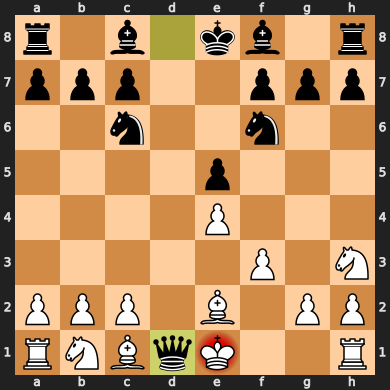

AI's move: e1d1


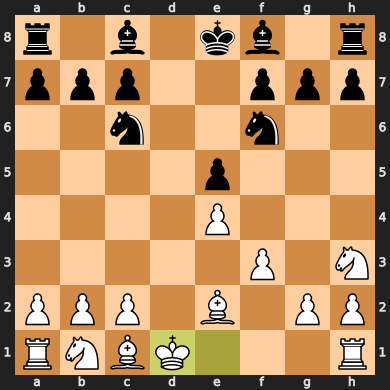

Enter your move (in algebraic notation, e.g., e2e4):  f8c5


Player's move: f8c5


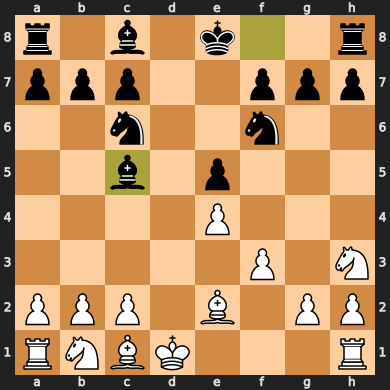

AI's move: c2c3


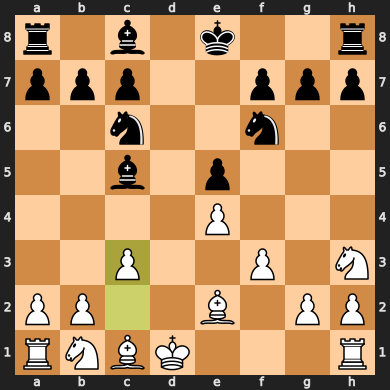

Enter your move (in algebraic notation, e.g., e2e4):  e8g8


Player's move: e8g8


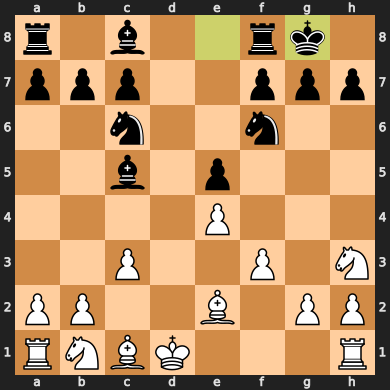

AI's move: e2d3


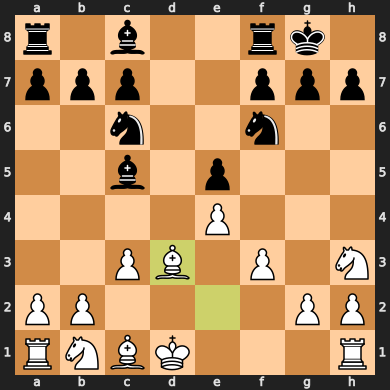

Enter your move (in algebraic notation, e.g., e2e4):  c8e6


Player's move: c8e6


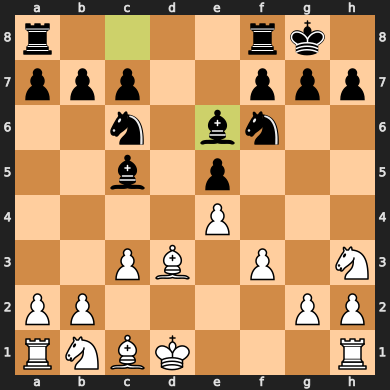

AI's move: d1d2


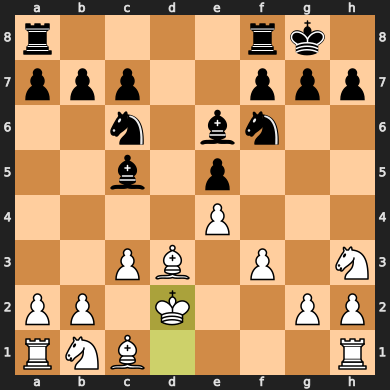

Enter your move (in algebraic notation, e.g., e2e4):  a8d8


Player's move: a8d8


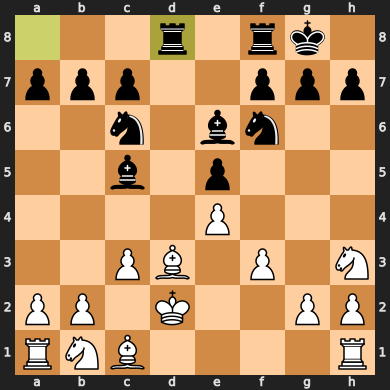

AI's move: d2e2


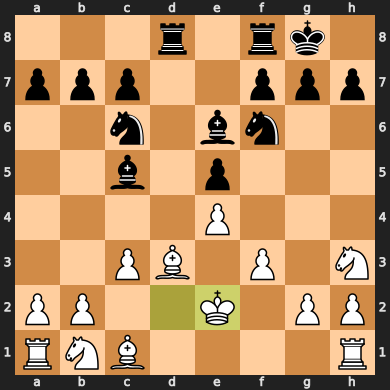

Enter your move (in algebraic notation, e.g., e2e4):  e6c4


Player's move: e6c4


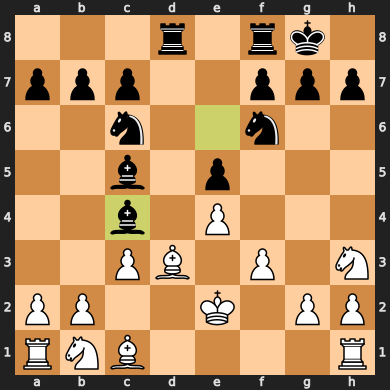

AI's move: c1d2


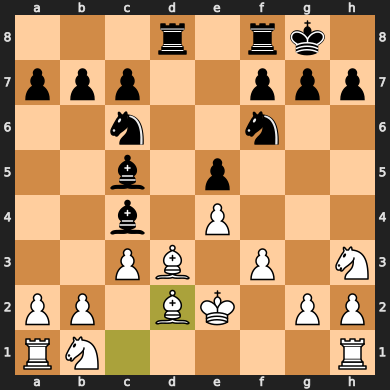

Enter your move (in algebraic notation, e.g., e2e4):  c4d3


Player's move: c4d3


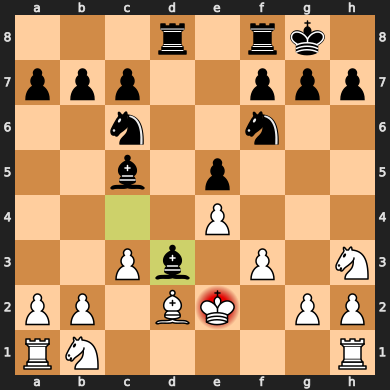

AI's move: e2d1


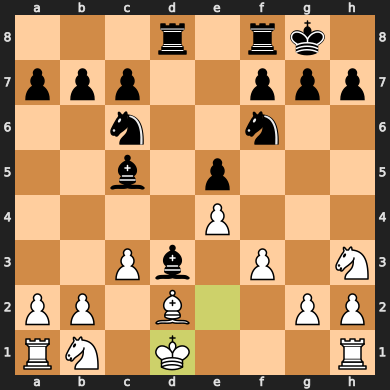

Enter your move (in algebraic notation, e.g., e2e4):  d3c2


Player's move: d3c2


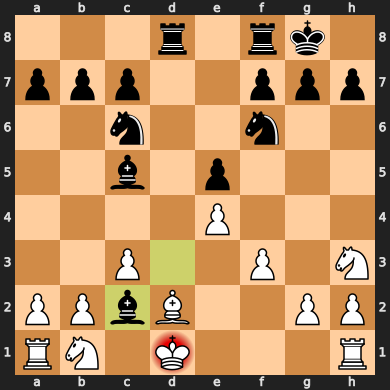

AI's move: d1c2


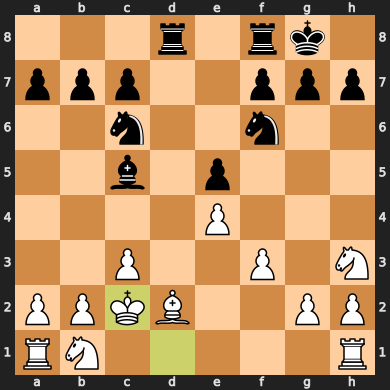

In [ ]:
game_loop()